In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.linalg
import scipy.optimize
# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [2]:
class Jackknife:
    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def __init__( self, nbins, binsize, binned ):
        self.binsize = binsize
        self.nbins = nbins
        self.N = self.binsize * self.nbins
        self.binned = binned
        self.jack_avg = []
        self.est = 0
        self.var_est = 0
        
        for i in range( 0, self.nbins ):
            resmpld = np.delete(binned, i, 0)
            self.jack_avg.append( np.mean(resmpld, 0) )
            
        self.do_it()

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)
    
def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+': '+'{num:.{width}f}'.format(num=(exact-cen)/err, width=i+1)+' sigma'

In [3]:
def theta(z, Tau, n=0, nmax=1e5, tol=1.0e-15):
    
    if n==0:
        r = np.pi*1.0j/Tau
        s = np.exp( -r*z**2 )

        s_old = s
        for ell in np.arange(1,nmax):
            s += np.exp( -r*(ell+z)**2 )
            s += np.exp( -r*(-ell+z)**2 )

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = 1.0 / np.sqrt(-1.0j*Tau)
        return coeff * s

    else:

        r = np.pi*1.0j/Tau
        arr = np.full(n+1, 0)
        arr[n]=1
        Hn = np.polynomial.hermite.Hermite( arr )

        coeff = Hn( np.sqrt(r)*z )
        exp = np.exp( -r*z**2 )
        s = coeff * exp

        s_old = s
        for ell in np.arange(1,nmax):
            coeff = Hn( np.sqrt(r)*(ell+z) )
            exp = np.exp( -r*(ell+z)**2 )
            s += coeff * exp

            coeff = Hn( np.sqrt(r)*(-ell+z) )
            exp = np.exp( -r*(-ell+z)**2 )
            s += coeff * exp

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*Tau)

        return coeff * s

In [4]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    return -coeff * s

def th3(z, n=0):
    return theta(z, tau, n)

def th4(z, n=0):
    return theta(z+0.5, tau, n)

In [5]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

def dP(z):
    coeff = (np.pi * th20*th30)**2
    
    f1 = th4(z) * th4(z,1) / th1(z)**2
    f2 = th4(z)**2 * th1(z,1) / th1(z)**3

    res = 2.0 * coeff * (f1-f2)
    
    return res

def ddP(z):    
    coeff = (np.pi * th20*th30)**2
    
    f1 = ( th4(z,1)**2 + th4(z) * th4(z,2) ) / th1(z)**2
    f2 = th4(z) * th4(z,1) * th1(z,1) / th1(z)**3
    f3 = th4(z)**2 * th1(z,2) / th1(z)**3
    f4 = th4(z)**2 * th1(z,1)**2 / th1(z)**4

    res = 2.0 * coeff * (f1 - 4.0*f2 -f3 + 3.0*f4 )
    
    return res

In [6]:
def P2(z):
    return th1p0/th20 * th2(z)/th1(z)

def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

def P4(z):
    return th1p0/th40 * th4(z)/th1(z)

# def P2Alt(z):
#     return np.sqrt( P(z)-e1 )
# def P3Alt(z):
#     return np.sqrt( P(z)-e2 )
# def P4Alt(z):
#     return np.sqrt( P(z)-e3 )

In [7]:
def dP2(z):
    return th1p0/th20 * ( th2(z,1)/th1(z) - th2(z)*th1(z,1)/th1(z)**2 )

def ddP2(z):
    return th1p0/th20 * ( th2(z,2)/th1(z) - 2.0*th2(z,1)*th1(z,1)/th1(z)**2 - th2(z)*th1(z,2)/th1(z)**2 + 2.0*th2(z)*th1(z,1)**2/th1(z)**3 )

In [8]:
def dP3(z):
    return th1p0/th30 * ( th3(z,1)/th1(z) - th3(z)*th1(z,1)/th1(z)**2 )

def ddP3(z):
    return th1p0/th30 * ( th3(z,2)/th1(z) - 2.0*th3(z,1)*th1(z,1)/th1(z)**2 - th3(z)*th1(z,2)/th1(z)**2 + 2.0*th3(z)*th1(z,1)**2/th1(z)**3 )

In [9]:
def dP4(z):
    return th1p0/th40 * ( th4(z,1)/th1(z) - th4(z)*th1(z,1)/th1(z)**2 )

def ddP4(z):
    return th1p0/th40 * ( th4(z,2)/th1(z) - 2.0*th4(z,1)*th1(z,1)/th1(z)**2 - th4(z)*th1(z,2)/th1(z)**2 + 2.0*th4(z)*th1(z,1)**2/th1(z)**3 )

In [10]:
def dedekind( t ):
    return np.exp( np.pi*1.0j*t/12.0 ) * theta(0.5*(t+1.0), 3.0*t)

In [11]:
def ZM( nu ):
    eta = dedekind( tau )
    coeff = 1.0/(2.0* np.abs(eta) )

    if nu == 2: res = coeff * np.abs(th20)
    elif nu == 3: res = coeff * np.abs(th30)
    elif nu == 4: res = coeff * np.abs(th40)
    elif nu == 1: res = 0.0
    
    return res

In [12]:
def ZI( nu ):
    res = 0.0
    
    for nup in range(1, 5):
        if nup == nu: continue
        else: res += ZM(nup)

    res -= ZM(nu)
    res *= 0.5
    
    return res

In [13]:
def ZMss_nu(z, nu):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = np.abs( th1(z) )**(1/4)
    
    if nu==1: numer=np.abs( th1(0.5*z) )
    elif nu==2: numer=np.abs( th2(0.5*z) )
    elif nu==3: numer=np.abs( th3(0.5*z) )
    elif nu==4: numer=np.abs( th4(0.5*z) )
    else: assert(false)
    
    return factor * numer/denom

In [14]:
def ZMtot():
    res = 0.0
    for nup in range(1, 5):
        res += ZM(nup)
    return res

In [15]:
def ss_corr_analytic(z):
    res = 0.0
    for nu in range(1,5):
        res += ZMss_nu( z,nu )

    res /= ZMtot()
    
    return res

In [16]:
def epseps_corr_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * np.abs( P2(z) )**2
    res += ZM( 3 ) * np.abs( P3(z) )**2
    res += ZM( 4 ) * np.abs( P4(z) )**2

    res /= ZMtot()
    
    return res

In [17]:
def T_1pt_analytic():
    res = 0.0
    
    res += ZM( 2 ) * e1
    res += ZM( 3 ) * e2
    res += ZM( 4 ) * e3

    res /= ZMtot()
    res *= -0.25
    
    return res

In [18]:
def TTconn2(z):
    return -0.25 * ( dP2(z)**2 - ddP2(z)*P2(z) )

def TTconn3(z):
    return -0.25 * ( dP3(z)**2 - ddP3(z)*P3(z) )

def TTconn4(z):
    return -0.25 * ( dP4(z)**2 - ddP4(z)*P4(z) )

def TT_conn_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * TTconn2(z)
    res += ZM( 3 ) * TTconn3(z)
    res += ZM( 4 ) * TTconn4(z)

    res /= ZMtot()
    
    return res

In [19]:
# Lx = 9
# Ly = 12
mult = 16 # 12
Lx = 3*mult
Ly = 3*mult

# tautil = 1.2*np.exp( 1.0j* 4.0/9.0 * np.pi)
tautil = 1.0*np.exp( 1.0j* 3.0/9.0 * np.pi)
tautil1 = np.real(tautil)
tautil2 = np.imag(tautil)

tau = Ly/Lx * tautil

# Nbintot = 535 # int(1e3)
Nbintot = 37 # int(1e3)
binsize = int(1e3)
# Nbintot = 4
# binsize = 1e2

nskip = 17 # int(1e2)
Nbin = Nbintot-nskip

Nbin

20

In [20]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

eta1 = -1.0/6.0 * th1(0, n=3)/th1(0, n=1)

In [21]:
e1, e2, e3

((5.898343969484771-1.4609949400041577e-15j),
 (-2.949171984742389+5.108115717832552j),
 (-2.9491719847423825-5.1081157178325505j))

In [22]:
# description="Lx"+str(Lx)+"Ly"+str(Ly)+"nu1"
description="Lx"+str(Lx)+"Ly"+str(Ly)+"nu1tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)
directory1="mult"+str(mult)+"/data_"+description+"/"

In [23]:
ell_tri = np.loadtxt("mult"+str(mult)+"/"+description+"ell.dat", delimiter=",")
kappa = np.loadtxt("mult"+str(mult)+"/"+description+"kappa.dat", delimiter=",")
ellstar = np.loadtxt("mult"+str(mult)+"/"+description+"ellstar.dat", delimiter=",")
e = np.loadtxt("mult"+str(mult)+"/"+description+"e.dat", delimiter=",")
cosH = np.loadtxt("mult"+str(mult)+"/"+description+"cosH.dat", delimiter=",")
beta = np.loadtxt("mult"+str(mult)+"/"+description+"beta.dat", delimiter=",")

In [24]:
0.5 * np.log(2.0 + np.sqrt(3.0))

0.6584789484624083

In [25]:
beta

array([0.65847895, 0.65847895, 0.65847895])

In [26]:
tanhBeta = np.tanh(beta)
coshBeta = np.cosh(beta)

In [27]:
DBetaDmu=-0.5*tanhBeta*coshBeta**2
DBetaDKappa = np.sinh(beta)*np.cosh(beta)/kappa

In [28]:
mat0 = np.array([
    [kappa[0], kappa[1], kappa[2]],
    [kappa[0]*e[0][0], kappa[1]*e[1][0], kappa[2]*e[2][0]],
    [kappa[0]*e[0][1], kappa[1]*e[1][1], kappa[2]*e[2][1]]
])

c=0.0

tilde_ell0 = np.linalg.inv(mat0)@np.array([c, 1.0, 0.0])
tilde_ell1 = np.linalg.inv(mat0)@np.array([c, 0.0, 1.0])

tilde_ell_tmp = np.array([tilde_ell0, tilde_ell1]).T

dualshift = (tilde_ell_tmp[2] - tilde_ell_tmp[0] - tilde_ell_tmp[1])/2.0

tmp_tilde = tilde_ell_tmp[2] + 2.0 * dualshift
tmp_tri = ell_tri[1] - ell_tri[0]

assert np.abs( tmp_tilde[1] / tmp_tilde[0] - tmp_tri[1] / tmp_tri[0] ) < 1.0e-14
relative = tmp_tilde[0] / tmp_tri[0]

tilde_ell = tilde_ell_tmp / relative

In [29]:
tilde_ell

array([[-1.00000000e+00,  1.73970538e-16],
       [ 5.00000000e-01, -8.66025404e-01],
       [ 5.00000000e-01,  8.66025404e-01]])

In [30]:
Ell=np.sqrt(np.array([
    ell_tri[0,0]**2 + ell_tri[0,1]**2,
    ell_tri[1,0]**2 + ell_tri[1,1]**2,
    ell_tri[2,0]**2 + ell_tri[2,1]**2
]))

Ellx = tilde_ell[1]-tilde_ell[0]+tilde_ell[2]-tilde_ell[0]
Elly = tilde_ell[2]-tilde_ell[0]+tilde_ell[2]-tilde_ell[1]

AEllx = np.sqrt( Ellx[0]*Ellx[0] + Ellx[1]*Ellx[1] )
AElly = np.sqrt( Elly[0]*Elly[0] + Elly[1]*Elly[1] )

In [31]:
ellstar

array([[-1.00000000e+00,  1.28197512e-16],
       [ 5.00000000e-01, -8.66025404e-01],
       [ 5.00000000e-01,  8.66025404e-01]])

In [32]:
Ellx

array([ 3.00000000e+00, -5.07037445e-16])

In [33]:
Elly/AEllx

array([0.5      , 0.8660254])

In [34]:
tau

(0.5000000000000001+0.8660254037844386j)

In [35]:
s = 0.5*( Ell[0]+Ell[1]+Ell[2] )
# Area_lat = np.sqrt( s*(s-Ell[0])*(s-Ell[1])*(s-Ell[2]) )

alat = 3.0 / AEllx / Lx
r = np.sqrt( s * alat )
# r = np.sqrt( alat )

Ntri = int(Lx*Ly * 2/3)

# optimalFit = [-0.146428, 0.900587]

alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])

alphaM = [alA, alB, alC]
Lxeff = int(Lx*2/3)

In [36]:
# s = 0.5*( Ell[0]+Ell[1]+Ell[2] )
# Area_lat = np.sqrt( s*(s-Ell[0])*(s-Ell[1])*(s-Ell[2]) )

# alat = 3.0 / AEllx / Lx
# r = np.sqrt( s * alat )

# Ntri = int(Lx*Ly * 2/3)

In [37]:
# kappa = 2.0/3.0
# cos = np.cos( np.pi/6.0 )
# B = cos / ( 1.0 - kappa**2 * cos**2 )
# alat = 1.0/Lx

# tanhbeta = kappa*cos

# alat = 1.0/Lx
# r = np.sqrt(3.0/2.0 * np.sqrt(3.0) * alat) # 

In [38]:
# eps = 1.0e-5
# zz = 0.2+0.3j
# ( P2( zz+eps )-P2( zz-eps ) ) / (2.0*eps)
# dP2(zz)

# generate lattice

In [39]:
Ntot = Lx*Ly

In [40]:
dualshift = (tilde_ell[2] - tilde_ell[0] - tilde_ell[1])/2.0

tmp_tilde = tilde_ell[2] + 2.0 * dualshift
tmp_tri = ell_tri[1] - ell_tri[0]

assert np.abs( tmp_tilde[1] / tmp_tilde[0] - tmp_tri[1] / tmp_tri[0] ) < 1.0e-14
relative = tmp_tilde[0] / tmp_tri[0]

In [41]:
pts_ = []
ppts_ = []

for yc in range(Ly):
    if yc==0:
        pts_.append( [ 0, 0, 0, 0, 0 ] )
    else:
        prev = pts_[-Lx]
        if yc%3!=1:
            pts_.append( [0, yc, 
                          prev[2]-0.5*ell_tri[0][0]*relative-0.5*tilde_ell[0][0], 
                          prev[3]-0.5*ell_tri[0][1]*relative-0.5*tilde_ell[0][1], 
                          (0-yc+Ntot)%3] )
        else:
            pts_.append( [0, yc, 
                          prev[2]+tilde_ell[2][0], 
                          prev[3]+tilde_ell[2][1], 
                          2] )
    
    if pts_[-1][4]!=1:
        ppts_.append( pts_[-1] )
            
    for xp in range(Lx-1):
        prev = pts_[-1]
        c = (xp-yc + Ntot)%3
        if c==1:
            pts_.append( [xp+1, yc, 
                          prev[2]-0.5*ell_tri[2][0]*relative+0.5*tilde_ell[2][0], 
                          prev[3]-0.5*ell_tri[2][1]*relative+0.5*tilde_ell[2][1], 
                          2] )
        elif c==2:
            pts_.append( [xp+1, yc, 
                          prev[2]-tilde_ell[0][0], 
                          prev[3]-tilde_ell[0][1], 
                          0 ] )
        else:
            pts_.append( [xp+1, yc, 
                          prev[2]+0.5*ell_tri[1][0]*relative+0.5*tilde_ell[1][0], 
                          prev[3]+0.5*ell_tri[1][1]*relative+0.5*tilde_ell[1][1], 
                          1 ] )
        
        if pts_[-1][4]!=1:
            ppts_.append( pts_[-1] )

pts = np.array( pts_ )
ppts = np.array( ppts_ )

pts.T[2] *= alat
pts.T[3] *= alat

ppts.T[2] *= alat
ppts.T[3] *= alat

In [42]:
type0_=[]
type1_=[]
type2_=[]
for pt in pts:
    if pt[-1]==0: type0_.append( pt )
    elif pt[-1]==1: type1_.append( pt )
    elif pt[-1]==2: type2_.append( pt )

In [43]:
type0 = np.array(type0_)
type1 = np.array(type1_)
type2 = np.array(type2_)

(-0.01, 0.1)

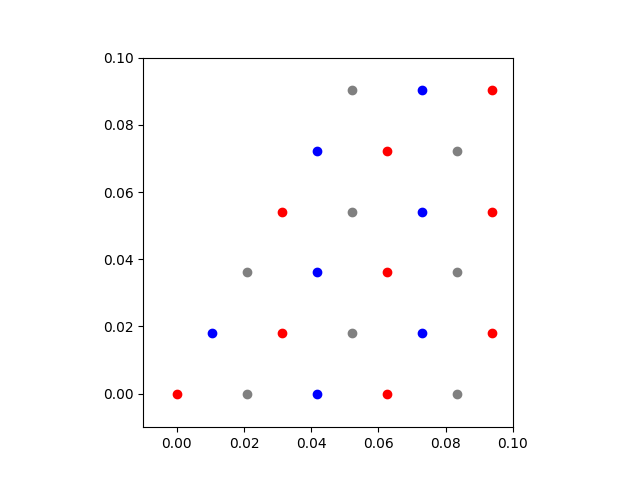

In [44]:
plt.close()
plt.plot( type0.T[2], type0.T[3], ls="none", marker="o", color='red' )
plt.plot( type1.T[2], type1.T[3], ls="none", marker="o", color='gray' )
plt.plot( type2.T[2], type2.T[3], ls="none", marker="o", color='blue' )
plt.gca().set_aspect('equal')
plt.xlim(-0.01, 0.1)
plt.ylim(-0.01, 0.1)

(-0.01, 0.1)

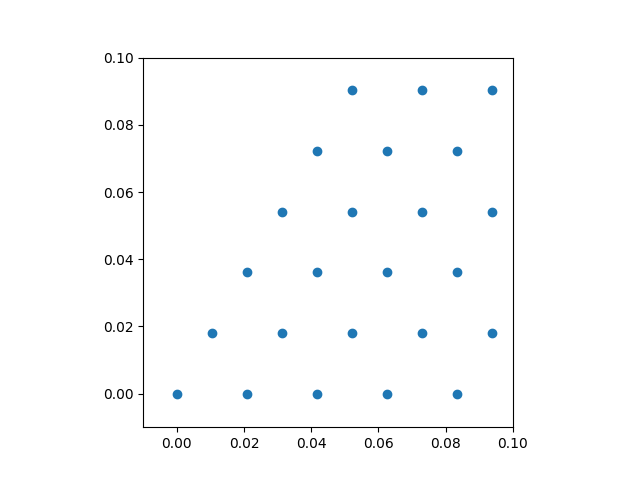

In [45]:
plt.close()
plt.plot( pts.T[2], pts.T[3], ls="none", marker="o" )
plt.gca().set_aspect('equal')
plt.xlim(-0.01, 0.1)
plt.ylim(-0.01, 0.1)

In [46]:
# isrc=xsrc+Lx*ysrc
# src = np.array([ pts[isrc][2], pts[isrc][3] ])
# src_cplx = src[0]+1.0j*src[1]

In [47]:
xlat_ = []
ylat_ = []
for i in range(Ntot):
    if np.abs(pts[i][-1])!=1:
        xlat_.append( pts[i][2] )
        ylat_.append( pts[i][3] )
xlat = np.array(xlat_)
ylat = np.array(ylat_)

In [48]:
def getSiteXY():
    # type2Shifted = np.array( [type2.T[2], type2.T[3] ] ).T + Delta*alat
    res_ = []
    for i in range(type0.shape[0]):
        if type0[i][2]<type2[i][2]:
            res_.append( [type0[i][2], type0[i][3]] )
            res_.append( [type2[i][2], type2[i][3]] )
        else:
            res_.append( [type2[i][2], type2[i][3]] )
            res_.append( [type0[i][2], type0[i][3]] )
    res = np.array(res_)
    return res

In [49]:
font = {'size'   : 12}
plt.rc('font', **font)

colors={
    2:'#006BA4',
    3:'#FF800E',
    4:'#ABABAB',
    "A":'#FFBC79',
    "B":'#5F9ED1',
    "C":'#C85200',
    6:'#898989',
    7:'#A2C8EC',
    8:'#595959',
    9:'#CFCFCF'
}

markers={
    2:"o", 
    3:"d", 
    4:"v", 
    "A":"x", 
    "B":"<", 
    "C":"^", 
}

# $\sigma\sigma$

In [50]:
Nbintot

37

In [51]:
ss_corr1 = np.array([np.loadtxt(directory1+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])
jk1 = Jackknife( Nbin, binsize, ss_corr1[nskip:] )

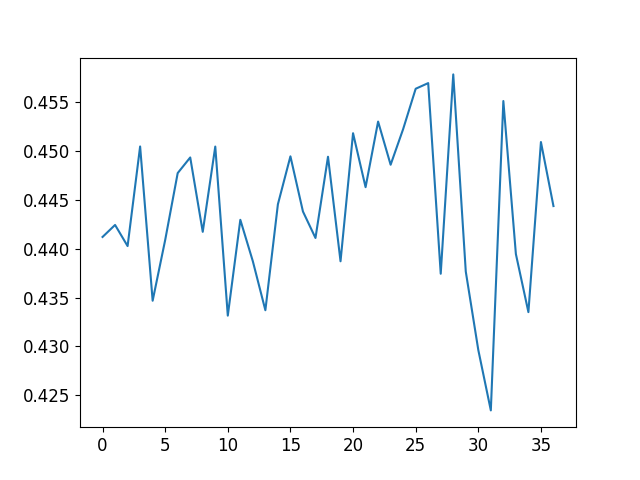

In [52]:
plt.clf()
plt.plot(ss_corr1[:,int(Lx/2),int(Lx/2)])
plt.show()

In [53]:
(ss_corr1[:,int(Lx/2),int(Lx/2)].shape)[0]/5

7.4

In [54]:
# y=np.mean(np.split(ss_corr1[:,int(Lx/2),int(Lx/2)], 5), axis=1)
# x=np.arange(y.shape[0])
# plt.clf()
# plt.plot( x, y )
# plt.show()

In [55]:
# plt.clf()
# plt.plot(ss_corr1[:,int(Lx/2),int(Lx/2)])
# plt.show()

In [56]:
shape = jk1.mean().shape
jkm = jk1.mean()
jke = jk1.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
ss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [57]:
XY = getSiteXY()

In [58]:
XY.shape

(1536, 2)

In [59]:
ss1.shape

(1536, 4)

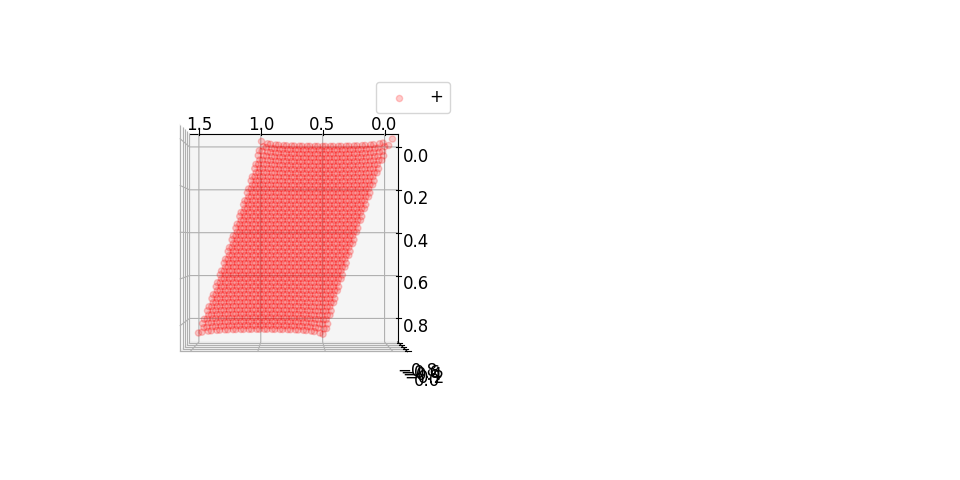

In [60]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log( ss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

plt.show()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# fig.tight_layout()
# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

In [61]:
alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])
alphaM = [alA, alB, alC]

def ArcTan( x, y ):
    tmp = np.arctan( y/x )
    if x<0:
        tmp += np.pi
    return tmp

tildeAlA = ArcTan( tilde_ell[0][0], tilde_ell[0][1] )
tildeAlB = ArcTan( tilde_ell[1][0], tilde_ell[1][1] )
tildeAlC = ArcTan( tilde_ell[2][0], tilde_ell[2][1] )

tildealphaM = [tildeAlA, tildeAlB, tildeAlC]

In [62]:
# # u = 1.65
# u = 1.7812633802904358
# u = 1.8987126040911464
# u = 2.0136047692899517

In [63]:
TildeEll = np.array([ 
    np.linalg.norm(tilde_ell[0]),
    np.linalg.norm(tilde_ell[1]), 
    np.linalg.norm(tilde_ell[2]) 
])

In [64]:
Ellstar = np.array([ 
    np.linalg.norm(ellstar[0]),
    np.linalg.norm(ellstar[1]), 
    np.linalg.norm(ellstar[2]) 
])

In [65]:
divs = np.array([0.23088000672608802, 0.2643308099111132, 0.24271706104663027])
# divs = 0.25, 0.25, 0.25

# numer = DBetaDKappa / ( alat * TildeEll )**0.25
numer = DBetaDKappa / ( alat * Ellstar )**0.25
denom = tanhBeta *DBetaDKappa + divs
rat = numer/denom

u = np.sqrt( np.mean(rat) )

In [66]:
gsq = (DBetaDKappa / divs)**8

In [67]:
DBetaDKappa / divs

array([5.62646426, 4.91444076, 5.35206755])

In [68]:
# def mat1(ell_):
#     res = np.array([
#         [ gsq[1]*ell_[0][0],-gsq[0]*ell_[1][0],               0.0, gsq[1]*ell_[0][1],-gsq[0]*ell_[1][1],               0.0],
#         [  kappa[0]*e[0][0],  kappa[1]*e[1][0],  kappa[2]*e[2][0],               0.0,               0.0,               0.0],
#         [  kappa[0]*e[0][1],  kappa[1]*e[1][1],  kappa[2]*e[2][1],               0.0,               0.0,               0.0],
#         [ gsq[2]*ell_[0][0],               0.0,-gsq[0]*ell_[2][0], gsq[2]*ell_[0][1],               0.0,-gsq[0]*ell_[2][1]],
#         [               0.0,               0.0,               0.0,  kappa[0]*e[0][0],  kappa[1]*e[1][0],  kappa[2]*e[2][0]],
#         [               0.0,               0.0,               0.0,  kappa[0]*e[0][1],  kappa[1]*e[1][1],  kappa[2]*e[2][1]]
#     ])
#     return res

# prime_ellP = tilde_ell
# prime_ellW = np.array([tilde_ell.T[0], tilde_ell.T[1]]).flatten()
# print(prime_ellW)

# prime_ellN = np.array(np.split(prime_ellW, 2)).T
# prime_ellM = prime_ellN

# prime_ellW = np.linalg.inv(mat1(prime_ellM))@np.array([1.0, 1.0, 0.0, 0.0, 0.0, 1.0])
# prime_ellP = prime_ellM
# prime_ellN = np.array(np.split(prime_ellW, 2)).T
# prime_ellM = 0.5*(prime_ellN+prime_ellP)
# print(prime_ellM)

In [69]:
tilde_ell_tmp = np.array([tilde_ell0, tilde_ell1]).T

dualshift = (tilde_ell_tmp[2] - tilde_ell_tmp[0] - tilde_ell_tmp[1])/2.0

tmp_tilde = tilde_ell_tmp[2] + 2.0 * dualshift
tmp_tri = ell_tri[1] - ell_tri[0]

assert np.abs( tmp_tilde[1] / tmp_tilde[0] - tmp_tri[1] / tmp_tri[0] ) < 1.0e-14
relative = tmp_tilde[0] / tmp_tri[0]

tilde_ell = tilde_ell_tmp / relative

In [70]:
u = np.sqrt( ( rat[0]*rat[1]*rat[2] )**(1.0/3.0) )

# div_eps = 0.7560526776531903 # 0.75
# const_sum = 0.5 * np.sum( tanhBeta**2 * np.cosh(beta)**2 )

# # ss_sum = 0.5*np.sum( tanhBeta * np.cosh(beta)**2 / (TildeEll*alat)**0.25 )
# ss_sum = 0.5*np.sum( tanhBeta * np.cosh(beta)**2 / (Ellstar*alat)**0.25 )
# denom = 1.0 - div_eps + const_sum
# u = np.sqrt( ss_sum/denom )

In [71]:
Lxeff

32

In [72]:
t = 0

yt = ss1[t*Lxeff:(t+1)*Lxeff]

fac = u**2
# fac = 3.4
# fac = 4.05
# fac = 0.29

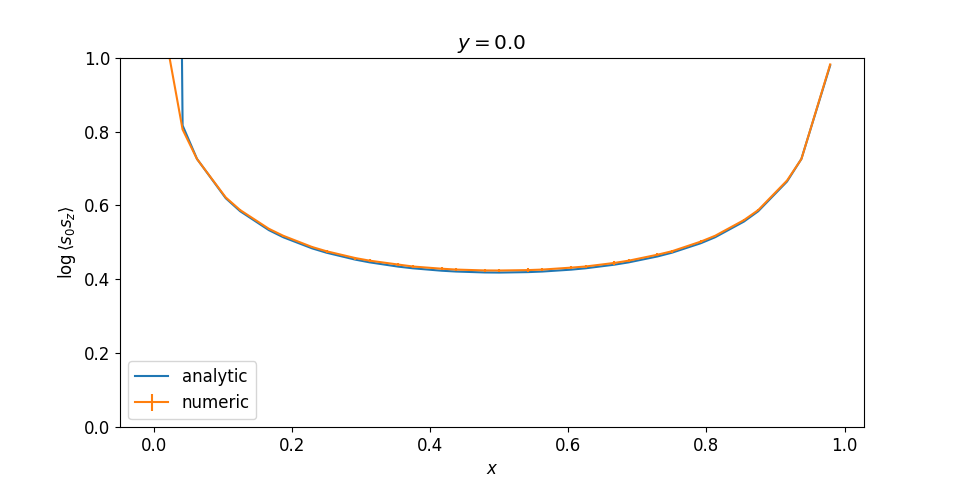

In [73]:
# plt.close()
plt.clf()
x = XY.T[0][t*Lxeff:(t+1)*Lxeff]
y = np.array( [ss_corr_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(y), label="analytic" )

plt.errorbar( x, np.log( fac * yt.T[2]), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

plt.legend()
plt.ylim( 0.0, 1.0 )

# plt.xscale("log")

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")
# plt.savefig('./ss_yslice_'+description+'.pdf',bbox_inches='tight')
plt.show()

In [74]:
# # plt.close()
# plt.clf()

# x = np.arange(0, Ly)/Ly
# y = np.array( [ss_corr_analytic( t/Lx + tau*yy ) for yy in x] )

# plt.plot( x, np.log(y), label="analytic" )
# plt.errorbar( xt.T[1]/Ly, np.log(fac * xt.T[2]), np.abs(xt.T[3]/xt.T[2]), label="numeric" )

# plt.legend()
# plt.ylim( 0.0, 1.0 )

# plt.title("$x="+str(t/Lx)+"$")
# plt.xlabel("$y$")
# plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")

# plt.savefig('./ss_xslice.pdf',bbox_inches='tight')
# plt.show()

# $\varepsilon$

In [75]:
div_eps = 0.75 # 0.7560526776531903

In [76]:
KA = np.array([np.loadtxt(directory1+"KA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KB = np.array([np.loadtxt(directory1+"KB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KC = np.array([np.loadtxt(directory1+"KC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [77]:
Ks = np.array([ KA, KB, KC ]).transpose()
eps_1pt_ori = - np.sum( DBetaDmu*tanhBeta ) + np.sum( DBetaDmu*Ks, axis=1 ) + 1.0 - div_eps

eps1 = 2.0*np.pi/r**2 * eps_1pt_ori

In [78]:
jk = Jackknife( Nbin, binsize, eps1[nskip:] )

In [79]:
eta = dedekind( tau )
sumTh = np.abs(th20) + np.abs(th30) + np.abs(th40)
eps_1pt_analytic = 2.0 * np.pi * np.abs(eta)**3 / sumTh

In [80]:
print( format_print( jk.mean(), jk.err() ) )
print( "exact", eps_1pt_analytic )

format_print_w_exact(eps_1pt_analytic, -jk.mean(), jk.err() )

-1.125(52)
exact 1.0654280014083615


'1.125(52): -1.146 sigma'

In [81]:
tanhBeta

array([0.57735027, 0.57735027, 0.57735027])

# $\varepsilon \varepsilon$

In [179]:
KAKA = np.array([np.loadtxt(directory1+"KAKA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KAKB = np.array([np.loadtxt(directory1+"KAKB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KAKC = np.array([np.loadtxt(directory1+"KAKC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

KBKA = np.array([np.loadtxt(directory1+"KBKA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KBKB = np.array([np.loadtxt(directory1+"KBKB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KBKC = np.array([np.loadtxt(directory1+"KBKC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

KCKA = np.array([np.loadtxt(directory1+"KCKA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KCKB = np.array([np.loadtxt(directory1+"KCKB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KCKC = np.array([np.loadtxt(directory1+"KCKC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [180]:
KKs = np.array([
    [KAKA, KAKB, KAKC],
    [KBKA, KBKB, KBKC],
    [KCKA, KCKB, KCKC]
])

In [183]:
epseps_analytic = np.array([ [elem[0], elem[1], 
                              eps_1pt_analytic**2 + epseps_corr_analytic(elem[0]+1.0j*elem[1]) ] for elem in XY] )

In [185]:
epseps_ = []

for step in np.arange( KKs[0][0].shape[0] ):
    tmp=np.full(KKs[0][0].shape[1:], 0.0)
    for iA in np.arange(3):
        for iB in np.arange(3):
            bracket = KKs[iA][iB][step] 
#            bracket -= Ks[step][iA]*Ks[step][iB]
            bracket += - Ks[step][iA]*tanhBeta[iB] - Ks[step][iB]*tanhBeta[iA] 
            bracket += tanhBeta[iA]*tanhBeta[iB]
            
            tmp+=DBetaDmu[iA]*DBetaDmu[iB]*bracket
        tmp+=2.0*DBetaDmu[iA]*(Ks[step][iA]-tanhBeta[iA])*(1.0-div_eps)
    tmp+=(1.0-div_eps)**2
    epseps_.append(tmp)
epseps = np.array( epseps_ )
#        epseps_+=

In [187]:
epseps_rescaled = (2.0*np.pi)**2/r**4 * epseps
jk = Jackknife( Nbin, binsize, epseps_rescaled[nskip:] )

In [188]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [XY.T[0][xx], XY.T[1][yy], 
                   jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
epseps1=np.array(np.split(tmp2, tmp2.shape[0]/4))

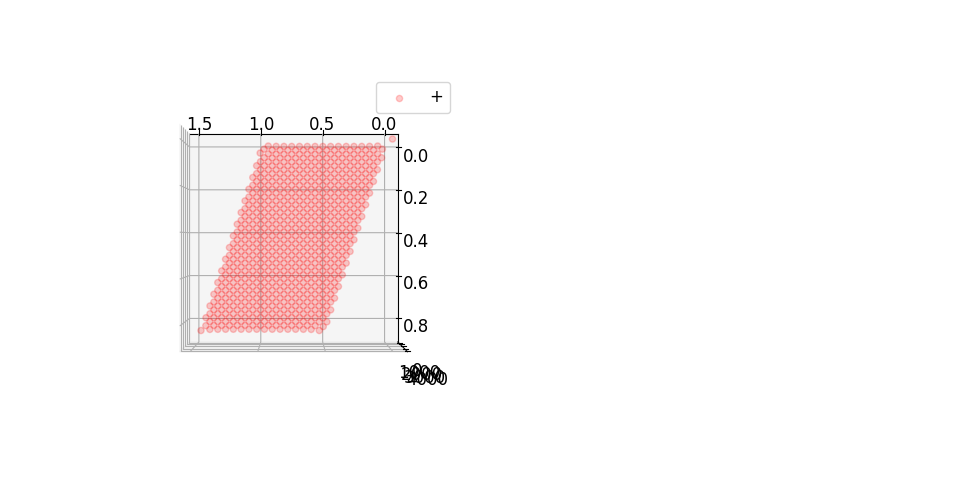

In [190]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], epseps1.T[2], c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# ax.set_zlim(9.38, 9.4)

plt.show()

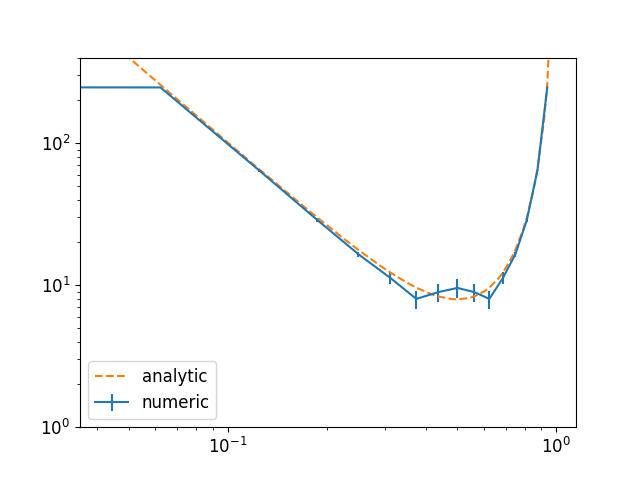

In [193]:
plt.close()
plt.clf()

plt.errorbar(
    epseps1.T[0][:int(Lxeff):2],
    # epseps1.T[0][:int(Lxeff):2], 
    epseps1.T[2][:int(Lxeff):2],
    epseps1.T[3][:int(Lxeff):2],
#    epseps.T[2][:int(2*Lx/3)] / rel**16,
    label="numeric"
        )

plt.plot(
    epseps_analytic.T[0][:int(Lxeff)],
    epseps_analytic.T[2][:int(Lxeff)],
    label="analytic", 
    ls="dashed"
)

plt.xscale("log")
plt.yscale("log")

plt.ylim(1, 400)

plt.legend()

plt.show()

## $T$

In [55]:
Txx = np.array([np.loadtxt(directory1+"Txx_"+str(i)+".dat") for i in range(1, Nbintot+1)])
Txy = np.array([np.loadtxt(directory1+"Txy_"+str(i)+".dat") for i in range(1, Nbintot+1)])

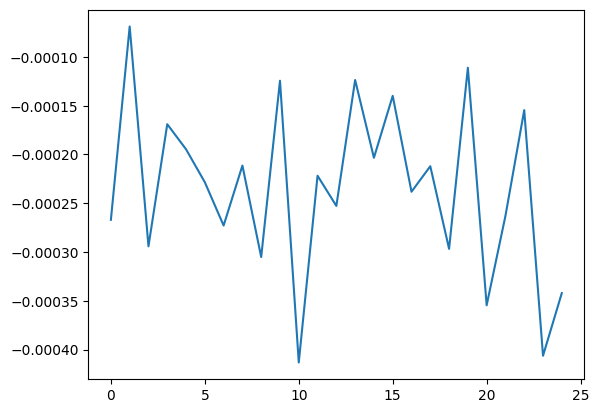

In [56]:
plt.clf()
plt.plot(Txx)
plt.show()

In [57]:
# Tnxx = -(2.0*np.pi) * 1.0/3.0 * (TB+TC-2.0*TA)/alat/r**2
# Tnxy = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (TC-TB)/alat/r**2

In [58]:
Tnxx = (2.0*np.pi) * Txx/(alat)/r**2
Tnxy = (2.0*np.pi) * Txy/(alat)/r**2

In [59]:
jkxx = Jackknife( Nbin, binsize, Tnxx[nskip:] )
jkxy = Jackknife( Nbin, binsize, Tnxy[nskip:] )

In [60]:
print( format_print( 0.5*jkxx.mean(), 0.5*jkxx.err() ) )

-0.650(52)


In [61]:
print( format_print( -0.5*jkxy.mean(), 0.5*jkxy.err() ) )

-1.207(49)


In [62]:
analy = T_1pt_analytic()

In [63]:
print("Re T", format_print( 0.5*jkxx.mean(), 0.5*jkxx.err() ), analy.real )
print("Im T", format_print( -0.5*jkxy.mean(), 0.5*jkxy.err() ), analy.imag )

Re T -0.650(52) -0.6364210140582482
Im T -1.207(49) -1.1023135313533934


In [64]:
Lx

48

In [65]:
Ly

24

## TT


In [67]:
tmp = np.array([[ [xx, yy, TT_conn_analytic(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
TTconn_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [68]:
TxxTxx = np.array([np.loadtxt(directory1+"TxxTxx_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [69]:
iii = Txx.shape[0]
TxxTxx_conn = np.array([TxxTxx[ii] - Txx[ii]**2 for ii in range(iii)])

In [70]:
jk = Jackknife( Nbin, binsize, TxxTxx_conn[nskip:] )

In [71]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
TxxTxx1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/scratch/247953.1.ood/ipykernel_985500/3264392977.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log( TxxTxx1.T[2]), c='r', marker='o', label="+")
/scratch/247953.1.ood/ipykernel_985500/3264392977.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log(-TxxTxx1.T[2]), c='b', marker='o', label="-")
/scratch/247953.1.ood/ipykernel_985500/3264392977.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])),
/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  ret

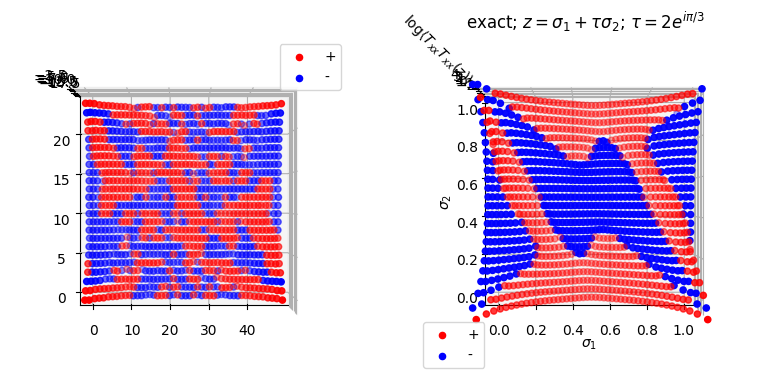

In [72]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log( TxxTxx1.T[2]), c='r', marker='o', label="+")
ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log(-TxxTxx1.T[2]), c='b', marker='o', label="-")
ax.legend()

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

plt.savefig('./TxxTxx.pdf',bbox_inches='tight')

In [73]:
t = 0 #  int(Ly/68)-1
yt = TxxTxx1[t*Lx:(t+1)*Lx]

/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/scratch/247953.1.ood/ipykernel_985500/388385768.py:11: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/scratch/247953.1.ood/ipykernel_985500/388385768.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


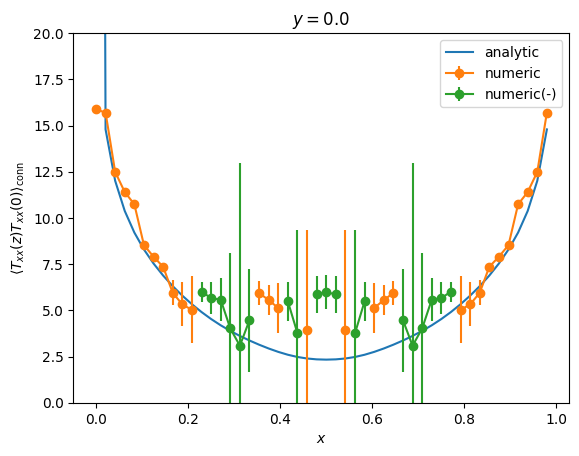

<Figure size 640x480 with 0 Axes>

In [74]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [TT_conn_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(2.0*y), label="analytic" )


fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

plt.savefig('./yslice.pdf',bbox_inches='tight')

In [75]:
TxxTxy = np.array([np.loadtxt(directory1+"TxxTxy_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [76]:
iii = Txx.shape[0]
TxxTxy_conn = np.array([TxxTxy[ii] - Txx[ii]*Txy[ii] for ii in range(iii)])

In [77]:
jk = Jackknife( Nbin, binsize, TxxTxy_conn[nskip:] )

In [78]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
TxxTxy1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/scratch/247953.1.ood/ipykernel_985500/3160716227.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log( TxxTxy1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/scratch/247953.1.ood/ipykernel_985500/3160716227.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log(-TxxTxy1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/scratch/247953.1.ood/ipykernel_985500/3160716227.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/scratch/247953.1.ood/ipykernel_985500/3160716227.py:20: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T

Text(0.5, 0.92, 'exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$')

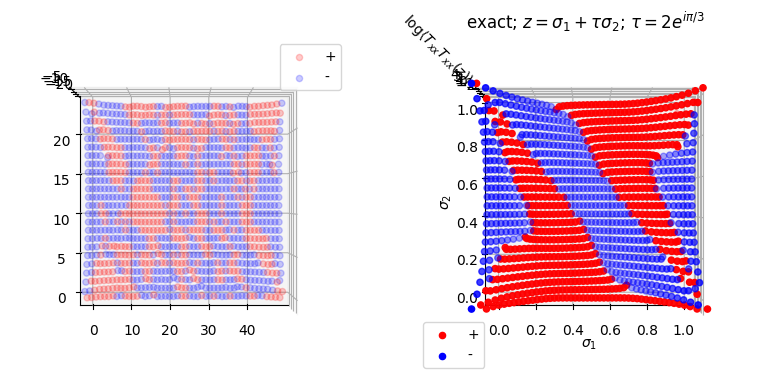

In [79]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log( TxxTxy1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log(-TxxTxy1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

In [80]:
t = 0 #  int(Ly/68)-1
yt = TxxTxy1[t*Lx:(t+1)*Lx]

/scratch/247953.1.ood/ipykernel_985500/473554130.py:11: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/scratch/247953.1.ood/ipykernel_985500/473554130.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


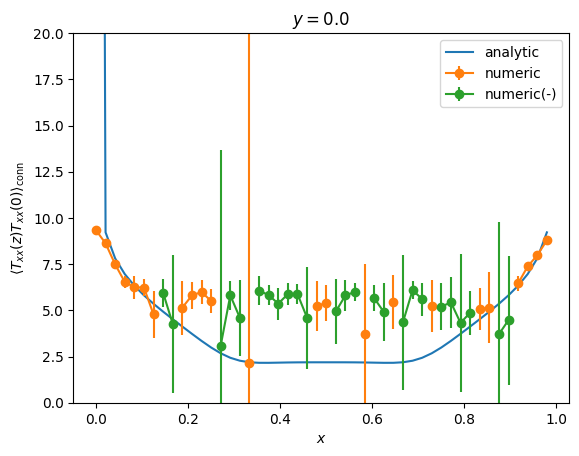

In [81]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [TT_conn_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(-2.0*np.imag(y)), label="analytic" )


fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

# plt.savefig('./yslice.pdf',bbox_inches='tight')

In [82]:
Txxss = np.array([np.loadtxt(directory1+"Txx_ss_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [83]:
iii = Txxss.shape[0]
Txxss_conn = np.array([Txxss[ii] - Txx[ii]*ss_corr1[ii] for ii in range(iii)])

In [84]:
jk = Jackknife( Nbin, binsize, Txxss_conn[nskip:] )

In [85]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Txxss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/scratch/247953.1.ood/ipykernel_985500/2061575007.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log( Txxss1.T[2]), c='r', marker='o', label="+")
/scratch/247953.1.ood/ipykernel_985500/2061575007.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log(-Txxss1.T[2]), c='b', marker='o', label="-")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


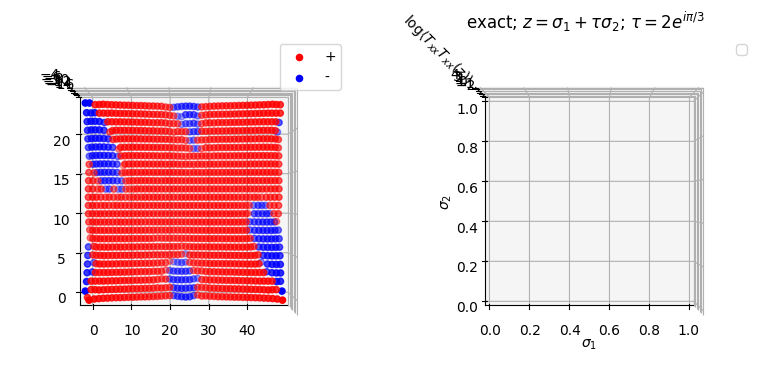

In [86]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log( Txxss1.T[2]), c='r', marker='o', label="+")
ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log(-Txxss1.T[2]), c='b', marker='o', label="-")
ax.legend()

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

# ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
#            c='r', marker='o', label="+")
# ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
#            c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

plt.savefig('./Txxss.pdf',bbox_inches='tight')

In [89]:
t = 3 #  int(Ly/68)-1
yt = Txxss1[t*Lx:(t+1)*Lx]

/scratch/247953.1.ood/ipykernel_985500/1592740195.py:11: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/scratch/247953.1.ood/ipykernel_985500/1592740195.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


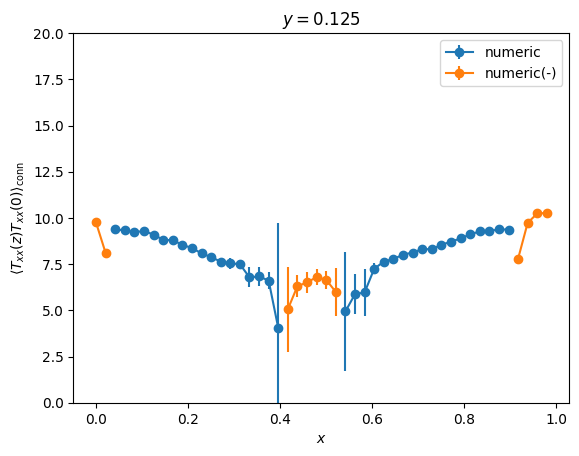

In [90]:
plt.close()

# x = np.arange(0, Lx)/Lx
# y = np.array( [TT_conn_analytic( xx + tau*t/Ly ) for xx in x] )
# plt.plot( x, np.log(2.0*y), label="analytic" )


fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

# plt.savefig('./yslice.pdf',bbox_inches='tight')

## CHECK

In [50]:
# Nbintot=120
# nskip = 20
# Nbin = Nbintot-nskip

KA = np.array([np.loadtxt(directory1+"KA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KB = np.array([np.loadtxt(directory1+"KB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KC = np.array([np.loadtxt(directory1+"KC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

FileNotFoundError: ./data_Lx9Ly12nu1/KA_1.dat not found.

In [57]:
t0 = KA - tanhbeta*B
jk = Jackknife( Nbin, binsize, t0[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.292603(21)'

In [58]:
t1 = KB - tanhbeta*B
jk = Jackknife( Nbin, binsize, t1[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.291102(21)'

In [59]:
t2 = KC - tanhbeta*B
jk = Jackknife( Nbin, binsize, t2[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.291001(20)'

In [60]:
tmp = t1+t2-2.0*t0
jk = Jackknife( Nbin, binsize, tmp[nskip:] )
format_print( jk.mean(), jk.err() )

'-0.003103(30)'

In [61]:
tmp = t2-t1
jk = Jackknife( Nbin, binsize, tmp[nskip:] )
format_print( jk.mean(), jk.err() )

'-0.000101(16)'

In [62]:
Txx_1pt = (2.0*np.pi) * 1.0/3.0 * (2.0*t0-t1-t2)/alat/r**2
Txy_1pt = (2.0*np.pi) * 1.0/np.sqrt(3.0) * (t2-t1)/alat/r**2
jk_xx = Jackknife( Nbin, binsize, Txx_1pt[nskip:] )
jk_xy = Jackknife( Nbin, binsize, Txy_1pt[nskip:] )
print(format_print( jk_xx.mean(), jk_xx.err()  ) )
print(format_print( jk_xy.mean(), jk_xy.err()  ) )

0.2026(20)
-0.0114(18)


In [63]:
analy = T_1pt_analytic()

In [68]:
print("Re T", format_print( 0.5*jk_xx.mean(), 0.5*jk_xx.err() ), analy.real )
print("Im T", format_print( -0.5*jk_xy.mean(), 0.5*jk_xy.err() ), analy.imag )

Re T 0.10132(99) 0.1075772266133182
Im T 0.00569(91) 0.006923613578085176
